# Integration test with O3 data

In [1]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
printint = np.vectorize(np.int)
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from scipy.io import loadmat
stochastic_mat = loadmat('/home/shivaraj.kandhasamy/stochastic/iso/misc/pyGWB/command/stochData_gwosc.mat',struct_as_record=False, squeeze_me=True)

# Analysis parameters

In [3]:
# Analysis parameters
IFO1 = 'H1'
IFO2 = 'L1'
t0 = 1247644138 # start GPS time
tf = 1247645038 # end GPS time
data_type='public' # private -> running on LIGO data grid
channel_suffix = 'GWOSC-16KHZ_R1_STRAIN' # detector name will be added later
new_sample_rate = 4096 # sampled rate after resampling
cutoff_frequency = 11 # high pass filter cutoff frequency
segment_duration = 192 # also fftlength in pre-processing
number_cropped_seconds = 2 # no. of secs to crop after highpass and resampling (default = 2 sec)
window_downsampling = "hamming" # filter used for downsampling (default = 'hamming')
ftype = "fir" # filter type used for downsampling
window_fftgram = "hann" # window used for fft (used CSD and PSD estimation)
overlap = segment_duration/2 # overlapping between segments
frequency_resolution = 1.0/32 # final frequency resolution of CSD and PSD 
polarization = 'tensor' # for regular analysis 
alpha = 0 # power law index
fref = 25 # Hz
flow = 20 # Hz
fhigh = 1726 # Hz
coarse_grain = 0  # 0 - pwelch PSD estimate; 1 - corase-grain PSD estimate 
if coarse_grain:
    fft_length = segment_duration
else:
    fft_length = int(1/frequency_resolution)

In [4]:
# Get data from public server and apply HP filter and downsample or HP filtered and downsampled data from matlab
# False - data from public server, True - data and ORF from matlab (for apple-to-apple comparison)
apple_to_apple = False

# Get data and pre-process data

In [5]:
from pygwb import preprocessing
from gwpy import timeseries

In [6]:
if not apple_to_apple:
    
    time_series_data1 = preprocessing.preprocessing_data_channel_name(IFO1,
                                                t0,
                                                tf,
                                                data_type,
                                                IFO1+':'+channel_suffix,
                                                new_sample_rate,
                                                cutoff_frequency,
                                                segment_duration,
                                                number_cropped_seconds=2,
                                                window_downsampling="hamming",
                                                ftype="fir",
                                                )
    
    time_series_data2 = preprocessing.preprocessing_data_channel_name(IFO2,
                                                t0,
                                                tf,
                                                data_type,
                                                IFO2+':'+channel_suffix,
                                                new_sample_rate,
                                                cutoff_frequency,
                                                segment_duration,
                                                number_cropped_seconds=2,
                                                window_downsampling="hamming",
                                                ftype="fir",
                                                )

else:
    
    time_series_data1 =  timeseries.TimeSeries(stochastic_mat['finaltimeseries1'], t0=1247644204, sample_rate=4096)
    time_series_data2 =  timeseries.TimeSeries(stochastic_mat['finaltimeseries2'], t0=1247644204, sample_rate=4096)

# Make PSDs and CSD

In [7]:
from pygwb import spectral
from pygwb.util import window_factors

In [8]:
naive_psd_1 = spectral.power_spectral_density(time_series_data1, segment_duration, frequency_resolution, window_fftgram= 'hann', overlap_factor=0.5)
# adjacent averaged PSDs (detector 1) for each possible CSD
avg_psd_1 = spectral.before_after_average(naive_psd_1, segment_duration, 2)

naive_psd_2 = spectral.power_spectral_density(time_series_data2, segment_duration, frequency_resolution, window_fftgram= 'hann', overlap_factor=0.5)
# adjacent averaged PSDs (detector 2) for each possible CSD
avg_psd_2 = spectral.before_after_average(naive_psd_2, segment_duration, 2)

# calcaulate CSD
csd = spectral.cross_spectral_density(time_series_data1, time_series_data2, segment_duration, 
                                        frequency_resolution, overlap_factor=0.5, zeropad=True, window_fftgram='hann')
                                           
# remove edge segments from navie PSDs and CSDs to match with average PSDs
stride = segment_duration - overlap
ind_edge_segments = int(np.ceil(segment_duration / stride))

csd = csd[ind_edge_segments:-(ind_edge_segments+1) + 1]

# also remove naive psds from edge segments
naive_psd_1 = naive_psd_1[ind_edge_segments:-(ind_edge_segments+1) + 1]
naive_psd_2 = naive_psd_2[ind_edge_segments:-(ind_edge_segments+1) + 1]

segment_starttime = csd.times.value # for later use

# calculate ORF

In [9]:
from pygwb import orfs
import bilby

In [10]:
# calculate ORF
interferometer_1 = bilby.gw.detector.get_empty_interferometer(IFO1)
interferometer_2 = bilby.gw.detector.get_empty_interferometer(IFO2)
if coarse_grain:
    freqs = np.arange(0, len(stochastic_mat['gamma']))*frequency_resolution
else:
    freqs = avg_psd_1.yindex.value
orf = orfs.calc_orf(
                    freqs,
                    interferometer_1.vertex,
                    interferometer_2.vertex,
                    interferometer_1.x,
                    interferometer_2.x,
                    interferometer_1.y,
                    interferometer_2.y,
                    polarization=polarization,
                    )
    
deltaF = freqs[1]-freqs[0]
try:
    assert abs(deltaF - frequency_resolution) < 1e-6 # within machine (floating point) precision
except ValueError:  
    print('Frequency resolution in PSD/CSD is different than requested.')
if apple_to_apple:
    orf = stochastic_mat['gamma']

# Band limiting

In [11]:
freq_band_cut = (freqs>=flow) & (freqs<=fhigh)
freqs = freqs[freq_band_cut]
naive_psd_1 = naive_psd_1.crop_frequencies(flow, fhigh+deltaF)
naive_psd_2 = naive_psd_2.crop_frequencies(flow, fhigh+deltaF)
avg_psd_1 = avg_psd_1.crop_frequencies(flow, fhigh+deltaF)
avg_psd_2 = avg_psd_2.crop_frequencies(flow, fhigh+deltaF)
csd = csd.crop_frequencies(flow, fhigh+deltaF)
orf = orf[freq_band_cut]
stochastic_mat['gamma'] = stochastic_mat['gamma'][freq_band_cut]

In [12]:
# Take CSD from matlab to see if there are any differences between coarsegraining function in matlab and pyGWB
from pygwb.util import window_factors
from gwpy.spectrogram import Spectrogram
if apple_to_apple:
    cc = np.zeros((len(csd),len(freqs)),dtype=complex)
    cc[0,:] = stochastic_mat["rrCG"][0].data
    cc[1,:] = stochastic_mat["rrCG"][1].data
    cc[2,:] = stochastic_mat["rrCG"][2].data
    csd = Spectrogram(cc, times=csd.xindex.value, frequencies=csd.yindex.value)
    w1w2bar, w1w2squaredbar, _, _ = window_factors(4096*192)
    const =  new_sample_rate / (w1w2bar * 4096*192)
    csd = 2* const * csd 

# calculate Y and sigma

In [13]:
from pygwb.constants import H0
from pygwb.constants import speed_of_light
from pygwb.util import window_factors

# window factors
w1w2bar, w1w2squaredbar, _, _ = window_factors(4096*192)

def calculate_Yf_varf(freqs, csd, avg_psd_1, avg_psd_2, orf, fref, alpha,):    
    S_alpha = 3 * H0**2 / (10 * np.pi**2) / freqs**3 * (freqs/fref)**alpha
    Y_fs = np.real(csd)/(orf * S_alpha)
    var_fs = 1 / (2 * segment_duration * (freqs[1]-freqs[0])) * avg_psd_1 * avg_psd_2 / (orf**2 * S_alpha**2)
    var_fs = var_fs * w1w2squaredbar / w1w2bar ** 2
    return Y_fs, var_fs

In [14]:
# Create Y_f and sigma_f of stochastic analysis for every segment
Y_fs, var_fs = calculate_Yf_varf(freqs, csd.value, 
                                   avg_psd_1.value, 
                                   avg_psd_2.value, 
                                   orf, fref, alpha)

# Frequency cuts/notches

In [15]:
notch_freq = np.real(stochastic_mat['ptEst_ff']==0)
Y_fs[:,notch_freq] = 0
var_fs[:,notch_freq] = np.Inf # some large number

# Make final point estimate and error bar

In [16]:
from pygwb import postprocessing
iso_job = postprocessing.IsotropicJob(Y_fs, (var_fs)**0.5, segment_starttime, segment_duration, new_sample_rate, frequencies=freqs)
Y_f = iso_job.combined_Y_spectrum
var_f = iso_job.combined_sigma_spectrum**2
Y_pyGWB, sigma_pyGWB = iso_job.calculate_broadband_statistics(0) # alpha = 0

2022-03-15 14:09:06.846 | DEBUG    | pygwb.postprocessing:_combine_non_time_dimension_even_odd:200 - Bias factor: 1.0503978496414612


In [17]:
# post-processing using modified expressions compared to Pat's
from pygwb.util import calc_bias

def postprocess_Y_sigma(Y_fs, var_fs):
    size = np.size(Y_fs, axis=0)
    _, w1w2squaredbar, _, w1w2squaredovlbar = window_factors(192*4096)
    k = (w1w2squaredovlbar / w1w2squaredbar)

    # even/odd indices
    evens = np.arange(0, size, 2)
    odds = np.arange(1, size, 2)

    X_even = np.nansum(Y_fs[evens] / var_fs[evens], axis=0)
    GAMMA_even = np.nansum(var_fs[evens] ** -1, axis=0)
    X_odd = np.nansum(Y_fs[odds] / var_fs[odds], axis=0)
    GAMMA_odd = np.nansum(var_fs[odds] ** -1, axis=0)  
    sigma2_oo = 1/np.nansum(GAMMA_odd)
    sigma2_ee = 1/np.nansum(GAMMA_even)
    sigma2_1 = 1/np.nansum(var_fs[0,:] ** -1)
    sigma2_N = 1/np.nansum(var_fs[-1,:] ** -1)
    sigma2IJ = (1/sigma2_oo + 1/sigma2_ee - (1/2) * (1/sigma2_1+1/sigma2_N))


    Y_f_new = (X_odd * (1- (k/2) * sigma2_oo * sigma2IJ) + X_even * (1- (k/2) * sigma2_ee * sigma2IJ))/ (
            GAMMA_even + GAMMA_odd - k * (GAMMA_even + GAMMA_odd - (1/2) * (1/var_fs[0,:] + 1/var_fs[-1,:])))

    inv_var_f_new = (GAMMA_odd + GAMMA_even - k * (GAMMA_odd + GAMMA_even - (1/2) * (1/var_fs[0,:] + 1/var_fs[-1,:]))) / (
            1- (k**2 /4) * sigma2_oo * sigma2_ee * sigma2IJ**2)
    bias = calc_bias(segment_duration, deltaF, 1 / new_sample_rate)
    var_f_new = (1 / inv_var_f_new) * bias**2
    var_f_new[notch_freq] = np.inf
    Y_f_new[notch_freq] = 0
    return Y_f_new, var_f_new


Y_f_new, var_f_new = postprocess_Y_sigma(Y_fs, var_fs)

<ipython-input-17-0f673e599794>:24: RuntimeWarning: invalid value encountered in true_divide
  Y_f_new = (X_odd * (1- (k/2) * sigma2_oo * sigma2IJ) + X_even * (1- (k/2) * sigma2_ee * sigma2IJ))/ (
<ipython-input-17-0f673e599794>:30: RuntimeWarning: divide by zero encountered in true_divide
  var_f_new = (1 / inv_var_f_new) * bias**2


In [18]:
Y_f = Y_f_new
var_f = var_f_new

# Comparison with Matlab

In [19]:
printint = np.vectorize(np.int)
print('Segment start times from Matlab: ' + str(stochastic_mat['segmentStartTime']))
print('Segment start times from pyGWB: ' + str(printint(segment_starttime)))

Segment start times from Matlab: [1247644396 1247644492 1247644588]
Segment start times from pyGWB: [1247644396 1247644492 1247644588]


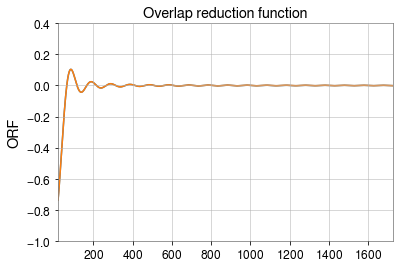

In [20]:
plt.plot(freqs, orf,label='pyGWB')
plt.plot(freqs, stochastic_mat['gamma'],label='matlab')
plt.title('Overlap reduction function')
plt.xlim([flow, 1726])
plt.xscale('linear')
plt.ylabel('ORF')
plt.ylim([-1,0.4])
plt.show()

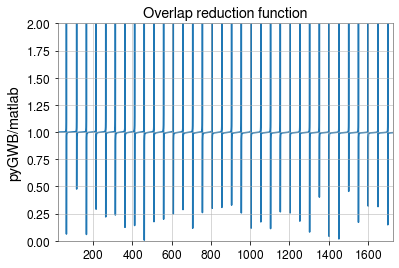

In [21]:
plt.plot(freqs, abs(orf)/abs(stochastic_mat['gamma']))
plt.title('Overlap reduction function')
plt.xlim([flow, fhigh])
plt.xscale('linear')
plt.ylabel('pyGWB/matlab')
plt.ylim([0,2])
plt.show()

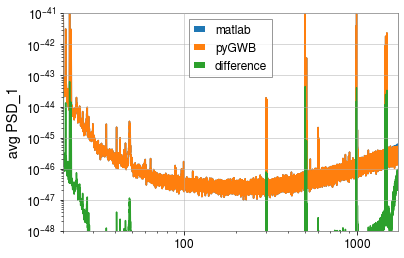

In [22]:
plt.loglog(stochastic_mat['freq'], stochastic_mat['calPSD1_avg'][0].data,label='matlab')
plt.loglog(stochastic_mat['freq'], avg_psd_1[0].value,label='pyGWB')
plt.loglog(stochastic_mat['freq'],abs(stochastic_mat['calPSD1_avg'][0].data-avg_psd_1[0].value),label='difference')
plt.xlim([flow, fhigh])
plt.ylabel('avg PSD_1')
plt.ylim([1e-48,1e-41])
plt.legend()
plt.show()

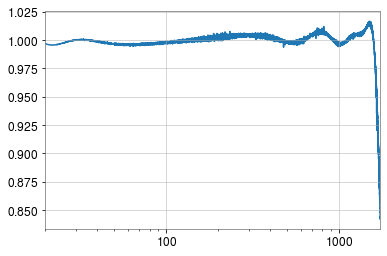

In [23]:
plt.semilogx(stochastic_mat['freq'], avg_psd_1[0].value/stochastic_mat['calPSD1_avg'][0].data)
plt.xlim([flow, fhigh])
plt.show()

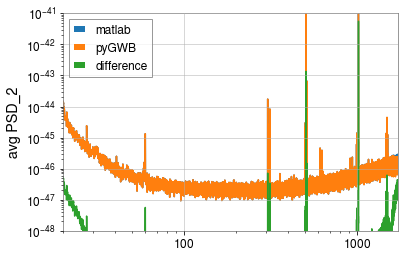

In [24]:
plt.loglog(stochastic_mat['freq'], stochastic_mat['calPSD2_avg'][0].data,label='matlab')
plt.loglog(stochastic_mat['freq'], avg_psd_2[0].value,label='pyGWB')
plt.loglog(stochastic_mat['freq'],abs(stochastic_mat['calPSD2_avg'][0].data-avg_psd_2[0].value),label='difference')
plt.xlim([flow, fhigh])
plt.ylabel('avg PSD_2')
plt.ylim([1e-48,1e-41])
plt.legend()
plt.show()

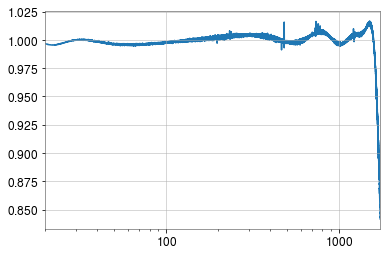

In [25]:
plt.semilogx(stochastic_mat['freq'], avg_psd_2[0].value/stochastic_mat['calPSD2_avg'][0].data)
plt.xlim([flow, fhigh])
plt.show()

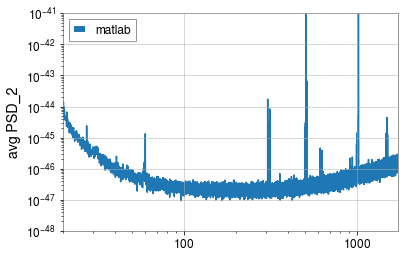

In [26]:
plt.loglog(stochastic_mat['freq'], stochastic_mat['calPSD2_avg'][0].data,label='matlab')
plt.xlim([flow, fhigh])
plt.ylabel('avg PSD_2')
plt.ylim([1e-48,1e-41])
plt.legend()
plt.show()

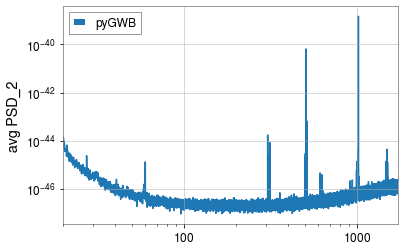

In [27]:
plt.loglog(stochastic_mat['freq'], avg_psd_2[0].value,label='pyGWB')
plt.xlim([flow, fhigh])
plt.ylabel('avg PSD_2')
#plt.ylim([1e-48,1e-41])
plt.legend()
plt.show()

/home/arianna.renzini/.conda/envs/AIRlab/lib/python3.8/site-packages/gwpy/plot/axes.py:135: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)
/home/arianna.renzini/.conda/envs/AIRlab/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


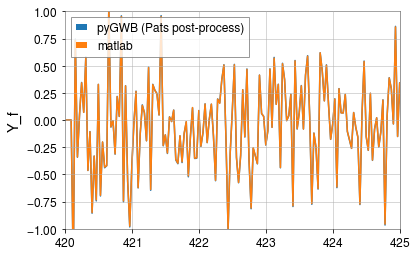

In [28]:
plt.plot(stochastic_mat['freq'], np.real(Y_f),label='pyGWB (Pats post-process)')
plt.plot(stochastic_mat['freq'], np.real(stochastic_mat['ptEst_ff']),label='matlab')
plt.xlim([flow, fhigh])
plt.ylabel('Y_f')
plt.ylim([-1,1])
plt.xlim([420, 425])
plt.legend()
plt.show()

<ipython-input-29-66291deb9868>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(stochastic_mat['freq'], Y_f/Y_f_matlab, label='(Pats post-process)')


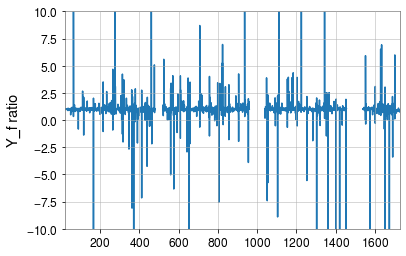

In [29]:
Y_f_matlab = np.real(stochastic_mat['ptEst_ff'])
plt.plot(stochastic_mat['freq'], Y_f/Y_f_matlab, label='(Pats post-process)')
plt.xlim(flow, fhigh)
plt.ylabel('Y_f ratio')
plt.ylim([-10, 10])
plt.xlim(20,1726)
plt.show()

/home/arianna.renzini/.conda/envs/AIRlab/lib/python3.8/site-packages/gwpy/plot/axes.py:135: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  super().draw(*args, **kwargs)


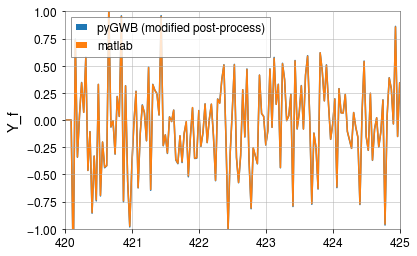

In [30]:
plt.plot(stochastic_mat['freq'], np.real(Y_f_new),label='pyGWB (modified post-process)')
plt.plot(stochastic_mat['freq'], np.real(stochastic_mat['ptEst_ff']),label='matlab')
plt.xlim([flow, fhigh])
plt.ylabel('Y_f')
plt.ylim([-1,1])
plt.xlim([420, 425])
plt.legend()
plt.show()

<ipython-input-31-57937291cd75>:2: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(stochastic_mat['freq'], Y_f_new/Y_f_matlab, label='(Modified post-process)')


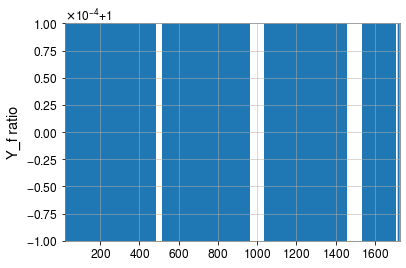

In [31]:
Y_f_matlab = np.real(stochastic_mat['ptEst_ff'])
plt.plot(stochastic_mat['freq'], Y_f_new/Y_f_matlab, label='(Modified post-process)')
plt.xlim(flow, fhigh)
plt.ylabel('Y_f ratio')
plt.ylim([-1e-4+1, 1e-4+1])
plt.xlim(20,1726)
plt.show()

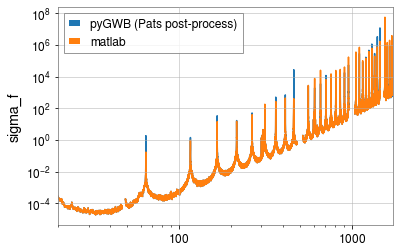

In [32]:
var_f[notch_freq] = np.inf
plt.loglog(freqs, np.sqrt(var_f),label='pyGWB (Pats post-process)')
plt.loglog(freqs, np.real(stochastic_mat['sigma_ff']),label='matlab')
plt.xlim([flow, fhigh])
plt.ylabel('sigma_f')
plt.legend()
plt.show()

<ipython-input-33-8c2e3eb4e655>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(freqs, np.sqrt(var_f)/np.real(stochastic_mat['sigma_ff']))


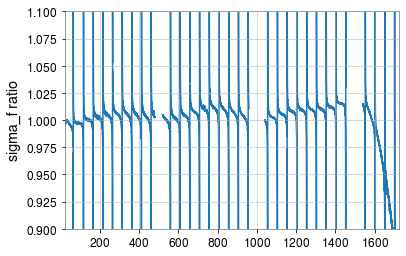

In [33]:
plt.plot(freqs, np.sqrt(var_f)/np.real(stochastic_mat['sigma_ff']))
plt.ylim(0.9, 1.1)
plt.xlim([flow, fhigh])
plt.ylabel('sigma_f ratio')
plt.xlim([20, 1726])
plt.show()

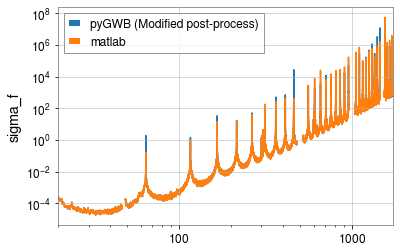

In [34]:
var_f_new[notch_freq] = np.inf
plt.loglog(freqs, np.sqrt(var_f_new),label='pyGWB (Modified post-process)')
plt.loglog(freqs, np.real(stochastic_mat['sigma_ff']),label='matlab')
plt.xlim([flow, fhigh])
plt.ylabel('sigma_f')
plt.legend()
plt.show()

<ipython-input-35-45efcd071de3>:1: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(freqs, np.sqrt(var_f_new)/np.real(stochastic_mat['sigma_ff']), label='(Modified post-process)' )


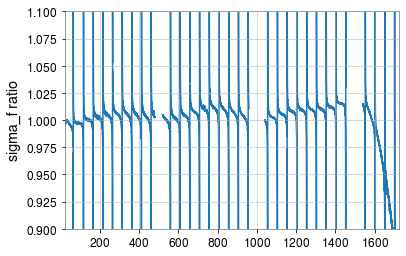

In [35]:
plt.plot(freqs, np.sqrt(var_f_new)/np.real(stochastic_mat['sigma_ff']), label='(Modified post-process)' )
plt.ylim(-1e-1+1, 1+1e-1)
plt.xlim([flow, fhigh])
plt.ylabel('sigma_f ratio')
plt.xlim([20, 1726])
plt.show()

In [36]:
from pygwb.util import calc_Y_sigma_from_Yf_varf
Y_maltab, sigma_matlab = calc_Y_sigma_from_Yf_varf(np.real(stochastic_mat['ptEst_ff']), stochastic_mat['sigma_ff']**2, freqs, alpha, fref)

In [37]:
Y_pyGWB_new, sigma_pyGWB_new = calc_Y_sigma_from_Yf_varf(Y_f_new, var_f_new, freqs, alpha, fref)

In [38]:
print('Comparing point estimates')
print('\tstochastic.m: %e'%(Y_maltab))
print('\tpyGWB (Pats post-process): %e'%(Y_pyGWB))
print('\t%% diff: %f%%'%(100*abs((Y_pyGWB-Y_maltab)/Y_maltab)))

print('Comparing sigmas')
print('\tstochastic.m: %e'%(sigma_matlab))
print('\tpyGWB (Pats post-process): %e'%(sigma_pyGWB))
print('\t%% diff: %f%%'%(100*abs((sigma_pyGWB-sigma_matlab)/sigma_matlab)))

Comparing point estimates
	stochastic.m: -2.974485e-06
	pyGWB (Pats post-process): -2.967180e-06
	% diff: 0.245591%
Comparing sigmas
	stochastic.m: 1.231366e-06
	pyGWB (Pats post-process): 1.229127e-06
	% diff: 0.181838%


In [39]:
print('Comparing point estimates')
print('\tstochastic.m: %e'%(Y_maltab))
print('\tpyGWB (modified post-process): %e'%(Y_pyGWB_new))
print('\t%% diff: %f%%'%(100*abs((Y_pyGWB_new-Y_maltab)/Y_maltab)))

print('Comparing sigmas')
print('\tstochastic.m: %e'%(sigma_matlab))
print('\tpyGWB (modified post-process): %e'%(sigma_pyGWB_new))
print('\t%% diff: %f%%'%(100*abs((sigma_pyGWB_new-sigma_matlab)/sigma_matlab)))

Comparing point estimates
	stochastic.m: -2.974485e-06
	pyGWB (modified post-process): -2.967180e-06
	% diff: 0.245591%
Comparing sigmas
	stochastic.m: 1.231366e-06
	pyGWB (modified post-process): 1.229127e-06
	% diff: 0.181838%
